## [Practical PyTorch: Generating Shakespeare with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

## Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the unidecode package (which you can install via pip or conda).


In [1]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('../data/shakespeare.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 1115394


In [2]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())


Come, gentlemen, let's all go visit him:
Pray God we may make haste, and come too late!

All:
Amen.

JOHN OF GAUNT:
Will the king come, that I may breathe my last
In wholesome counsel to his unstaid y


## Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden): # one char manually 
        input = self.encoder(input.view(1,-1)) # batch_size=1, input_size
        
        # GRU input (seq_len, batch, input_size): seq_len=1,batch=1
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        
        # GRU output (seq_len, batch, hidden_size * num_directions)
        output = self.decoder(output.view(1,-1))
        return output, hidden
    
    def init_hidden(self):
        # GRU init hidden 
        # h_0 (num_layers * num_directions, batch, hidden_size): 
        # tensor containing the initial hidden state 
        # for each element in the batch. 
        # Defaults to zero if not provided.
        return Variable(torch.zeros(self.n_layers,1,self.hidden_size))

## Inputs and Targets
Each chunk will be turned into a tensor, specifically a LongTensor (used for integer values), by looping through the characters of the string and looking up the index of each character in all\_characters.

In [4]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(n_characters) # = vocab_size = 100
print(all_characters)
print(char_tensor('abcDEF'))

100
0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Variable containing:
 10
 11
 12
 39
 40
 41
[torch.LongTensor of size 6]



Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters up to the last, and the target will be all characters from the first. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [5]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

## Evaluating
To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [6]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str
    
    for p in range(len(prime_str)-1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # sample from multinomial distribution of output
        output_dist = output.data.view(-1).div(temperature).exp() # no need to sum to 1
        top_i = torch.multinomial(output_dist,1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)
    
    return predicted

## Training


In [7]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    
    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])
    
    loss.backward()
    decoder_optimizer.step()
    
    return loss.data[0]/chunk_len

In [9]:
n_steps = 2000
print_every = 100
plot_every = 10
hidden_size = 100
embed_size = 50
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, embed_size, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() # so we don't need logsoftmax layer and NLLLoss

start = time.time()
all_losses = []
loss_avg = 0

for step in range(1, n_steps + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if step % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), step, step / n_steps * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if step % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

# too slow, change to gpu?

 51s (100 5%) 2.4062]
Whe, the that thoung
Whe and lou got heat I shad thif-upeSr shy fase ar stiendt wit we gale ond Whe ro 

 43s (200 10%) 2.1430]
Whe at be a liding dow med shos cor wirimy my in porsied,
Herpin dese; wod hand dimad inte me and ates 

 36s (300 15%) 2.0886]
Why Muct!
Or, excle carl's, there's wilt my scaos feave hear
'ever ustid lich the mar and the sapes

M 

 27s (400 20%) 1.7978]
Whord is parriendeld:
As the cond. 3 abeutenten heporemrer--
The carden in day didter and reded ad you 

 18s (500 25%) 1.7155]
Where!
Dous cown soole fored man's proan and the'ers food my le?

ARETES:
And bacef lo demald foolly n 

 10s (600 30%) 1.9935]
Whell thy beforeid shall thy mreceemers this my see bry why speath.
Nob's we plate. shall sange
Thigh, 

 2s (700 35%) 1.9168]
Why Andatter so have or and he cair, not and ome, so bothy ard,
Them on deagtl, and mes say chister, d 

 54s (800 40%) 1.8645]
Wher your to comes love
My coneston mest and Tobout your diary.

ANIO:
And he cook'

## Plotting the Training Losses
Plotting the historical loss from all_losses shows the network learning:

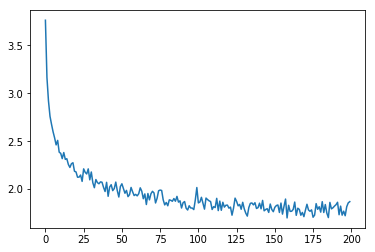

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Evaluating at different "temperatures"
In the evaluate function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the temperature argument.

In [11]:
print(evaluate('Th', 200, temperature=0.8))

Thereastmen these by with I but, I'll case.
I brow they speak the what I worth that.

Thark:
In the conllow, I for by please reasen
porteel him chake they hand from anot treet are sand these conner:
Sha


In [12]:
print(evaluate('Th', 200, temperature=0.2))

There speaken the seet the some the shall the shall the seet the shall the sut the should the seet
The shall the should the seet the seet the stand,
And the son the should the should the such the some t


In [13]:
print(evaluate('Th', 200, temperature=1.4))

There blusopen,
Ten troubed to yoy, For
Here time. O herconswelnuty I so; I wajin-wirnitly
My hip son chreade me, sube.
Whay, had I wild-fut not-
Unot uply sutthan'sproutuner his trough thot
us, all's f
